[*********************100%%**********************]  1 of 1 completed

2024-08-18 00:47:54.805332
2004-08-18 00:47:54.805332



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
c:\Users\chuac\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


0.04409098905752986
0.10066872577989838
0.02178789987793788
0.05470458696236748
0.04691037456785035
0.10526080579230493
0.07172984309302194
0.12171406462016167
0.06394591563721144
0.042137180419646994


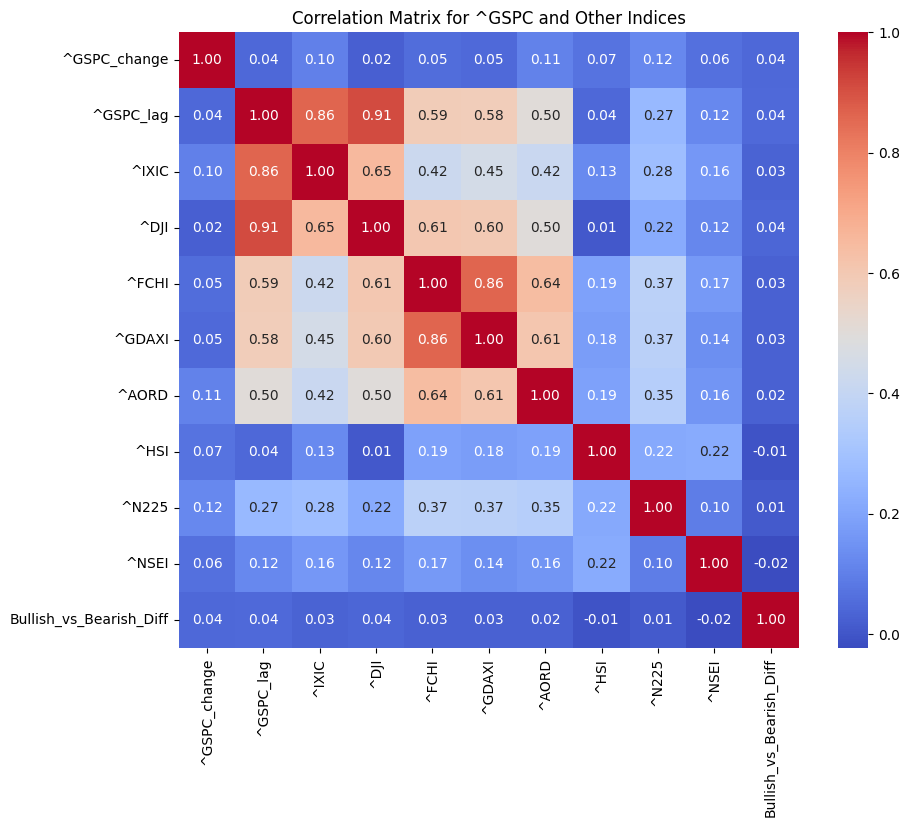

(51.42052124911951, 48.5325193707443)
(54.87203568912891, 45.08100493073491)
(50.55177271660014, 49.40126790326368)
(51.42052124911951, 48.5559990608124)
(51.678797839868515, 48.274242779995305)
(52.876262033341156, 46.959380136182205)
(53.46325428504344, 46.46630664475229)
(54.23808405729045, 45.71495656257337)
(53.5571730453158, 46.395867574548014)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(3407, 7)
(792, 7)
(3407, 1)
(792, 1)
torch.Size([3397, 10, 7])
torch.Size([3397, 1])
torch.Size([782, 10, 7])
torch.Size([782, 1])
Epoch [60/60], MSE: 485.72, MAPE: 0.66
Average MSE: 2119.10, Average MAPE: 1.18


In [32]:
%run Predictions.ipynb

### Final Model Predictions on entire Dataset

In [33]:
predictions_tensors = torch.cat(predictions, dim=0)
predictions_list = predictions_tensors.flatten().tolist()

In [34]:
calc_profit_df = final_df[['Date', f'{target_stock}_change', 'Price', 'Close']].iloc[test_index:]

calc_profit_df_top10 = calc_profit_df.iloc[:10]
calc_profit_df_top10 = calc_profit_df_top10.copy()
calc_profit_df_bot10 = calc_profit_df.iloc[10:].reset_index(drop=True)

calc_profit_df_top10['Predicted_Gain'] = np.nan
calc_profit_df_bot10['Predicted_Gain'] = pd.DataFrame(predictions_list, columns=['Predicted_Gain'])
calc_profit_df = pd.concat([calc_profit_df_top10, calc_profit_df_bot10])
# print(calc_profit_df)

In [35]:
# Utilise Bollinger Bands to gauge trend and decide on whether to long or short
def calc_profit(data):
    # Applying Bollinger Bands with Exponential Moving Average
    window = 20  
    data['EMA'] = data['Price'].ewm(span=window, adjust=True).mean()
    data['STD'] = data['Price'].rolling(window=window).std()
    data['Upper_Band'] = data['EMA'] + (2 * data['STD'])
    data['Lower_Band'] = data['EMA'] - (2 * data['STD'])
    data.dropna(inplace=True, ignore_index=True)
    
    # Decide on whether to short or long the stock
    orders = []
    for _, row in data.iterrows():
        if row['Price'] > row['Upper_Band']:
            orders.append(-1)
        elif row['Price'] < row['Lower_Band']:
            orders.append(1)
        elif row['Predicted_Gain'] > 0:
            orders.append(1)
        elif row['Predicted_Gain'] < 0:
            orders.append(-1) 
    
    data['Order'] = pd.DataFrame(orders, columns=['Order'])
     
    data['Profit Per Trade'] = data[f'{target_stock}_change'] * data['Order']
    data['Cumulative Profit'] = data['Profit Per Trade'].cumsum()
    data['Hold'] = data[f'{target_stock}_change'].cumsum()
    return data

In [36]:
final_df = calc_profit(calc_profit_df)
print(final_df)

          Date  ^GSPC_change        Price        Close  Predicted_Gain  \
0   2021-07-22     19.930176  4361.270020  4367.479980       -1.287429   
1   2021-07-23     28.379883  4381.200195  4411.790039       -0.589095   
2   2021-07-26      6.799805  4409.580078  4422.299805        0.886245   
3   2021-07-27    -13.429688  4416.379883  4401.459961        1.678960   
4   2021-07-28      0.639648  4402.950195  4400.640137        1.046008   
..         ...           ...          ...          ...             ...   
768 2024-08-12     25.100098  5351.879883  5344.390137       -0.074273   
769 2024-08-13     65.379883  5376.979980  5434.430176        0.396305   
770 2024-08-14     58.770020  5442.359863  5455.209961        1.833575   
771 2024-08-15     29.370117  5501.129883  5543.220215        2.032650   
772 2024-08-16     29.370117  5530.500000  5554.250000        4.010916   

             EMA         STD   Upper_Band   Lower_Band  Order  \
0    4333.710232   40.519366  4414.748964  425

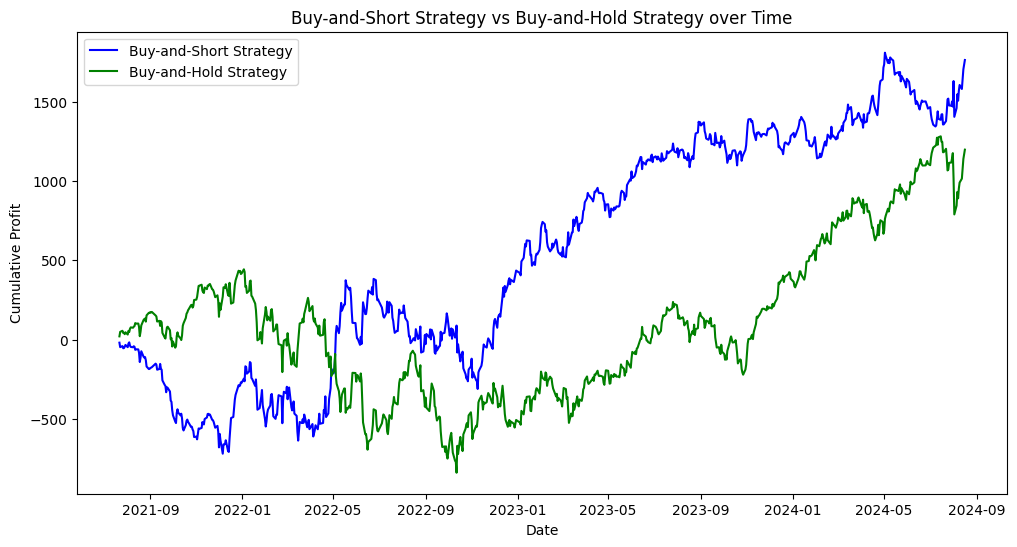

In [37]:
plt.figure(figsize=(12, 6))

plt.plot(final_df['Date'], final_df['Cumulative Profit'], label='Buy-and-Short Strategy', color='blue')
plt.plot(final_df['Date'], final_df['Hold'], label='Buy-and-Hold Strategy', color='green')
# Plotting Price, Upper_Band and Lower_Band
# plt.plot(final_df['Date'], final_df['Upper_Band'], label='Upper_Band', color='red')
# plt.plot(final_df['Date'], final_df['Lower_Band'], label='Lower_Band', color='red')
# plt.plot(final_df['Date'], final_df['Price'], label='Price', color='black')

plt.title('Buy-and-Short Strategy vs Buy-and-Hold Strategy over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.show()

### BackTest Strategy

In [38]:
def calc_sharpe_ratio(data, risk_free_rate):
    data['Wealth'] = data['Cumulative Profit'] + data.loc[data.index[0], 'Price']
    data['Return'] =  np.log(data['Wealth']) - np.log(data['Wealth'].shift(1))
    daily_return = data['Return'].dropna()
    excess_return = daily_return - risk_free_rate / 252
    daily_sharpe = excess_return.mean() / excess_return.std(ddof=1)
    yearly_sharpe = (252**0.5) * daily_sharpe
    return daily_sharpe, yearly_sharpe

def calc_max_drawdown(data):
    data['Wealth'] = data['Cumulative Profit'] + data.loc[data.index[0], 'Price']
    data['Peak'] = data['Wealth'].cummax()
    data['Drawdown'] = (data['Peak'] - data['Wealth']) / data['Peak']
    max_drawdown = data['Drawdown'].max()
    return max_drawdown

In [39]:
calc_sharpe_ratio(final_df, 0.05)

(0.025564628808998575, 0.4058259011297255)

In [40]:
calc_max_drawdown(final_df)

0.16179825503662032

In [41]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'model_state_dict.pth')